In [16]:
import zipfile
import os
import numpy as np
import pathlib
import pandas as pd
from math import ceil
import tensorflow as tf
import numpy as np
import IPython.display as display
import keras
from keras import backend as K
from matplotlib import pyplot as plt


print(tf.__version__)


root_path = './'
dataset_path = os.path.join(root_path, 'tf_dataset')

models_path = os.path.join(root_path, 'saved_models')
if not os.path.exists(models_path):
  os.mkdir(models_path)

1.13.1


## Load Data Set

In [17]:
BATCH_SIZE = 32


image_feature_description = {
    'enc': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
    'age': tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
    'img': tf.io.FixedLenSequenceFeature([], tf.string, allow_missing=True)
}


def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)


raw_train_dataset = tf.data.TFRecordDataset(os.path.join(dataset_path,'train.tfrecords'))
parsed_train_dataset = raw_train_dataset.map(_parse_image_function)

raw_val_dataset = tf.data.TFRecordDataset(os.path.join(dataset_path, 'val.tfrecords'))
parsed_val_dataset = raw_val_dataset.map(_parse_image_function)

raw_test_dataset = tf.data.TFRecordDataset(os.path.join(dataset_path, 'test.tfrecords'))
parsed_test_dataset = raw_test_dataset.map(_parse_image_function)


parsed_train_dataset = parsed_train_dataset.repeat()
parsed_train_dataset = parsed_train_dataset.shuffle(1000)
parsed_train_dataset = parsed_train_dataset.batch(BATCH_SIZE)
dataset_iterator = parsed_train_dataset.make_one_shot_iterator()

variable_dataset = dataset_iterator.get_next()

## Model Design

In [18]:
enc_len = 128
age_len = 8
img_shape = (32, 32, 3)
width, height, depth = (32, 32, 3)
img_len = np.prod(img_shape)
latent_dim = enc_len + age_len + img_len
noise_len = 16  # 32 x 32 x 3
input_dim = enc_len + age_len + noise_len
cond_len = enc_len + age_len


def build_discriminator():
    model = keras.Sequential([
        # dense 1
        keras.layers.Dense(144, input_shape=(latent_dim,)),
        keras.layers.Activation(tf.nn.relu),
        keras.layers.Dropout(0.2),
        
        # output
        keras.layers.Dense(1),
        keras.layers.Activation(tf.nn.sigmoid),
    ])
    
    # condition
    c1 = keras.layers.Input(shape=(enc_len,))
    c2 = keras.layers.Input(shape=(age_len,))
    
    # image
    z = keras.layers.Input(shape=img_shape)
    
    # flatten image
    z_flat = keras.layers.Flatten()(z)
    
    # concatenation
    inputs = keras.layers.concatenate([c1, c2, z_flat])
    
    # real or fake
    outputs = model(inputs)
    
    return keras.models.Model([c1, c2, z], outputs)


def build_generator():
    model = keras.Sequential([
        
        # dense 1
        keras.layers.Dense(144, input_shape=(input_dim,)),
        keras.layers.Activation(tf.nn.relu),
        keras.layers.Dropout(0.2),
        
        # reshape 1d to 3d
        keras.layers.Reshape((12, 12, 1)),
        
        # transpose conv block 1
        keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), padding='same'),
        keras.layers.Activation(tf.nn.relu),
        keras.layers.UpSampling2D(size=(2,2)),
        keras.layers.Dropout(0.2),
        
        # transpose conv block 2
        keras.layers.Conv2DTranspose(filters=2, kernel_size=(3, 3), padding='same'),
        keras.layers.Activation(tf.nn.relu),
        keras.layers.UpSampling2D(size=(2,2)),
        keras.layers.Dropout(0.2),
        
        # flatten
        keras.layers.Flatten(),
        
        # dense 3
        keras.layers.Dense(3072),
        keras.layers.Activation(tf.nn.relu),
        keras.layers.Dropout(0.2),
        
        # reshape 1d to 3d
        keras.layers.Reshape((width, height, depth)),
        
        # output
        keras.layers.Activation(tf.nn.tanh),
    ])
    
    # condition
    c1 = keras.layers.Input(shape=(enc_len,))
    c2 = keras.layers.Input(shape=(age_len,))
    
    # noise
    x = keras.layers.Input(shape=(noise_len,))

    # concatenation
    inputs = keras.layers.concatenate([c1, c2, x])
    
    # real or fake
    outputs = model(inputs)
    
    return keras.models.Model([c1, c2, x], outputs)


generator = build_generator()
discriminator = build_discriminator()

In [19]:
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 8)            0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 16)           0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 152)          0           input_10[0][0]                   
                                                                 input_11[0][0]                   
          

In [20]:
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 8)            0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 3072)         0           input_15[0][0]                   
__________________________________________________________________________________________________
concatenat

## Generative Adversarial Network

In [21]:
GLR = 0.02  # generator
DLR = 0.001  # discriminator


discriminator.compile(
    optimizer=keras.optimizers.Adam(lr=DLR),
    loss=keras.losses.kullback_leibler_divergence,
    metrics=['accuracy']
)


# condition
c1 = keras.layers.Input(shape=(enc_len,))
c2 = keras.layers.Input(shape=(age_len,))

# noise
x = keras.layers.Input(shape=(noise_len,))

# freeze discriminator
discriminator.trainable = False

# output
z = generator([c1, c2, x])
out = discriminator([c1, c2, z])

# GAN
gan = keras.models.Model(inputs=[c1, c2, x], outputs=out)

gan.compile(
    optimizer=keras.optimizers.Adam(lr=GLR),
    loss=keras.losses.kullback_leibler_divergence,
    metrics=['accuracy'])

In [22]:
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 8)            0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 16)           0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 32, 32, 3)    14180910    input_16[0][0]                   
                                                                 input_17[0][0]                   
          

## Train Model

In [ ]:
EPOCHS = 10000
STEPS = 1024 // BATCH_SIZE


train_loss_g = []
train_loss_d = []

train_acc_g = []
train_acc_d = []


y_fake = tf.zeros((BATCH_SIZE,))
y_true = tf.ones((BATCH_SIZE,))


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.40

with tf.Session(config=config) as sess:

  K.set_session(sess)
  
  tf.initialize_all_variables().run()

  # run once
  y_fake = y_fake.eval()
  y_true = y_true.eval()

  # epochs
  for e in range(EPOCHS):

    #batches
    loss = []
    acc = []

    for p in range(STEPS):

      values = sess.run([variable_dataset])
      row = values[0]

      sz = row['img'].shape[0]

#       if sz != BATCH_SIZE:
#         continue

      # train discriminator

      # fake data
      c1 = row['enc']
      c2 = tf.cast(row['age'], tf.float32).eval()
      x = tf.random.normal((sz, noise_len,)).eval()
      z_fake = generator.predict([c1, c2, x])

      # real data
      c1 = row['enc']
      c2 = tf.cast(row['age'], tf.float32).eval()
      z_real = tf.reshape(tf.io.decode_raw(row['img'], tf.uint8), (-1, width, height, depth)).eval()

      # train
      loss_1, acc_1 = discriminator.train_on_batch([c1, c2, z_fake], y_fake)
      loss_2, acc_2 = discriminator.train_on_batch([c1, c2, z_real], y_true)

      batch_loss = 0.5 * (float(tf.reduce_mean(loss_1).eval()) + float(tf.reduce_mean(loss_2).eval()))
      batch_acc = 0.5 * (float(tf.reduce_mean(acc_1).eval()) + float(tf.reduce_mean(acc_2).eval()))

      loss.append(batch_loss)
      acc.append(batch_acc)

    train_loss_d.append(np.mean(np.array(loss)))
    train_acc_d.append(np.mean(np.array(acc)))

    #batches
    loss = []
    acc = []

    for p in range(STEPS):

      values = sess.run([variable_dataset])
      row = values[0]

      sz = row['img'].shape[0]

#       if sz != BATCH_SIZE:
#         continue

      # train generator

      # concatenate face + age + noise
      c1 = row['enc']
      c2 = tf.cast(row['age'], tf.float32).eval()
      x = tf.random.normal((sz, noise_len,)).eval()

      # train
      loss_1, acc_1 = gan.train_on_batch([c1, c2, x], y_true)

      batch_loss = float(tf.reduce_mean(loss_1).eval())
      batch_acc = float(tf.reduce_mean(acc_1).eval())

      loss.append(batch_loss)
      acc.append(batch_acc)

    train_loss_g.append(np.mean(np.array(loss)))
    train_acc_g.append(np.mean(np.array(acc)))


    print("Epoch: {}, Steps: {}, Discriminator Loss: {:.3f}, Discriminator Accuracy: %{:.2f}, GAN Loss: {:.3f}, GAN Accuracy: %{:.2f}".format(
          e,
          STEPS,
          train_loss_d[-1],
          train_loss_g[-1],
          train_acc_d[-1],
          train_acc_g[-1]
      ))
 
    if e % 100 == 1:

      pth = os.path.join(models_path, 'gan.h5')
      gan.save(pth)

      pth = os.path.join(models_path, 'generator-{}-{}-{}.h5'.format(e, train_loss_g[-1], train_acc_g[-1]))
      generator.save(pth)

      pth = os.path.join(models_path, 'discriminator.h5')
      discriminator.save(pth)

        
sess.close()

## Plot Loss

In [ ]:
plt.plot(train_loss_g, label="Generator Loss");
plt.plot(train_loss_d, label="Discriminator Loss");
plt.legend();

## Plot Accuracy

In [ ]:
plt.plot(train_acc_g, label="Generator Accuracy");
plt.plot(train_acc_d, label="Discriminator Accuracy");
plt.legend()

## Visualize Generator Outputs

In [23]:
with tf.Session() as sess:

    tf.initialize_all_variables().run()

    values = sess.run([variable_dataset])
    row = values[0]

    sz = row['img'].shape[0]

    # fake data
    c1 = row['enc']
    c2 = tf.cast(row['age'], tf.float32).eval()
    x = tf.random.normal((sz, noise_len,)).eval()
    z_fake = generator.predict([c1, c2, x])
    z_real = tf.reshape(tf.io.decode_raw(row['img'], tf.uint8), (-1, width, height, depth)).eval()

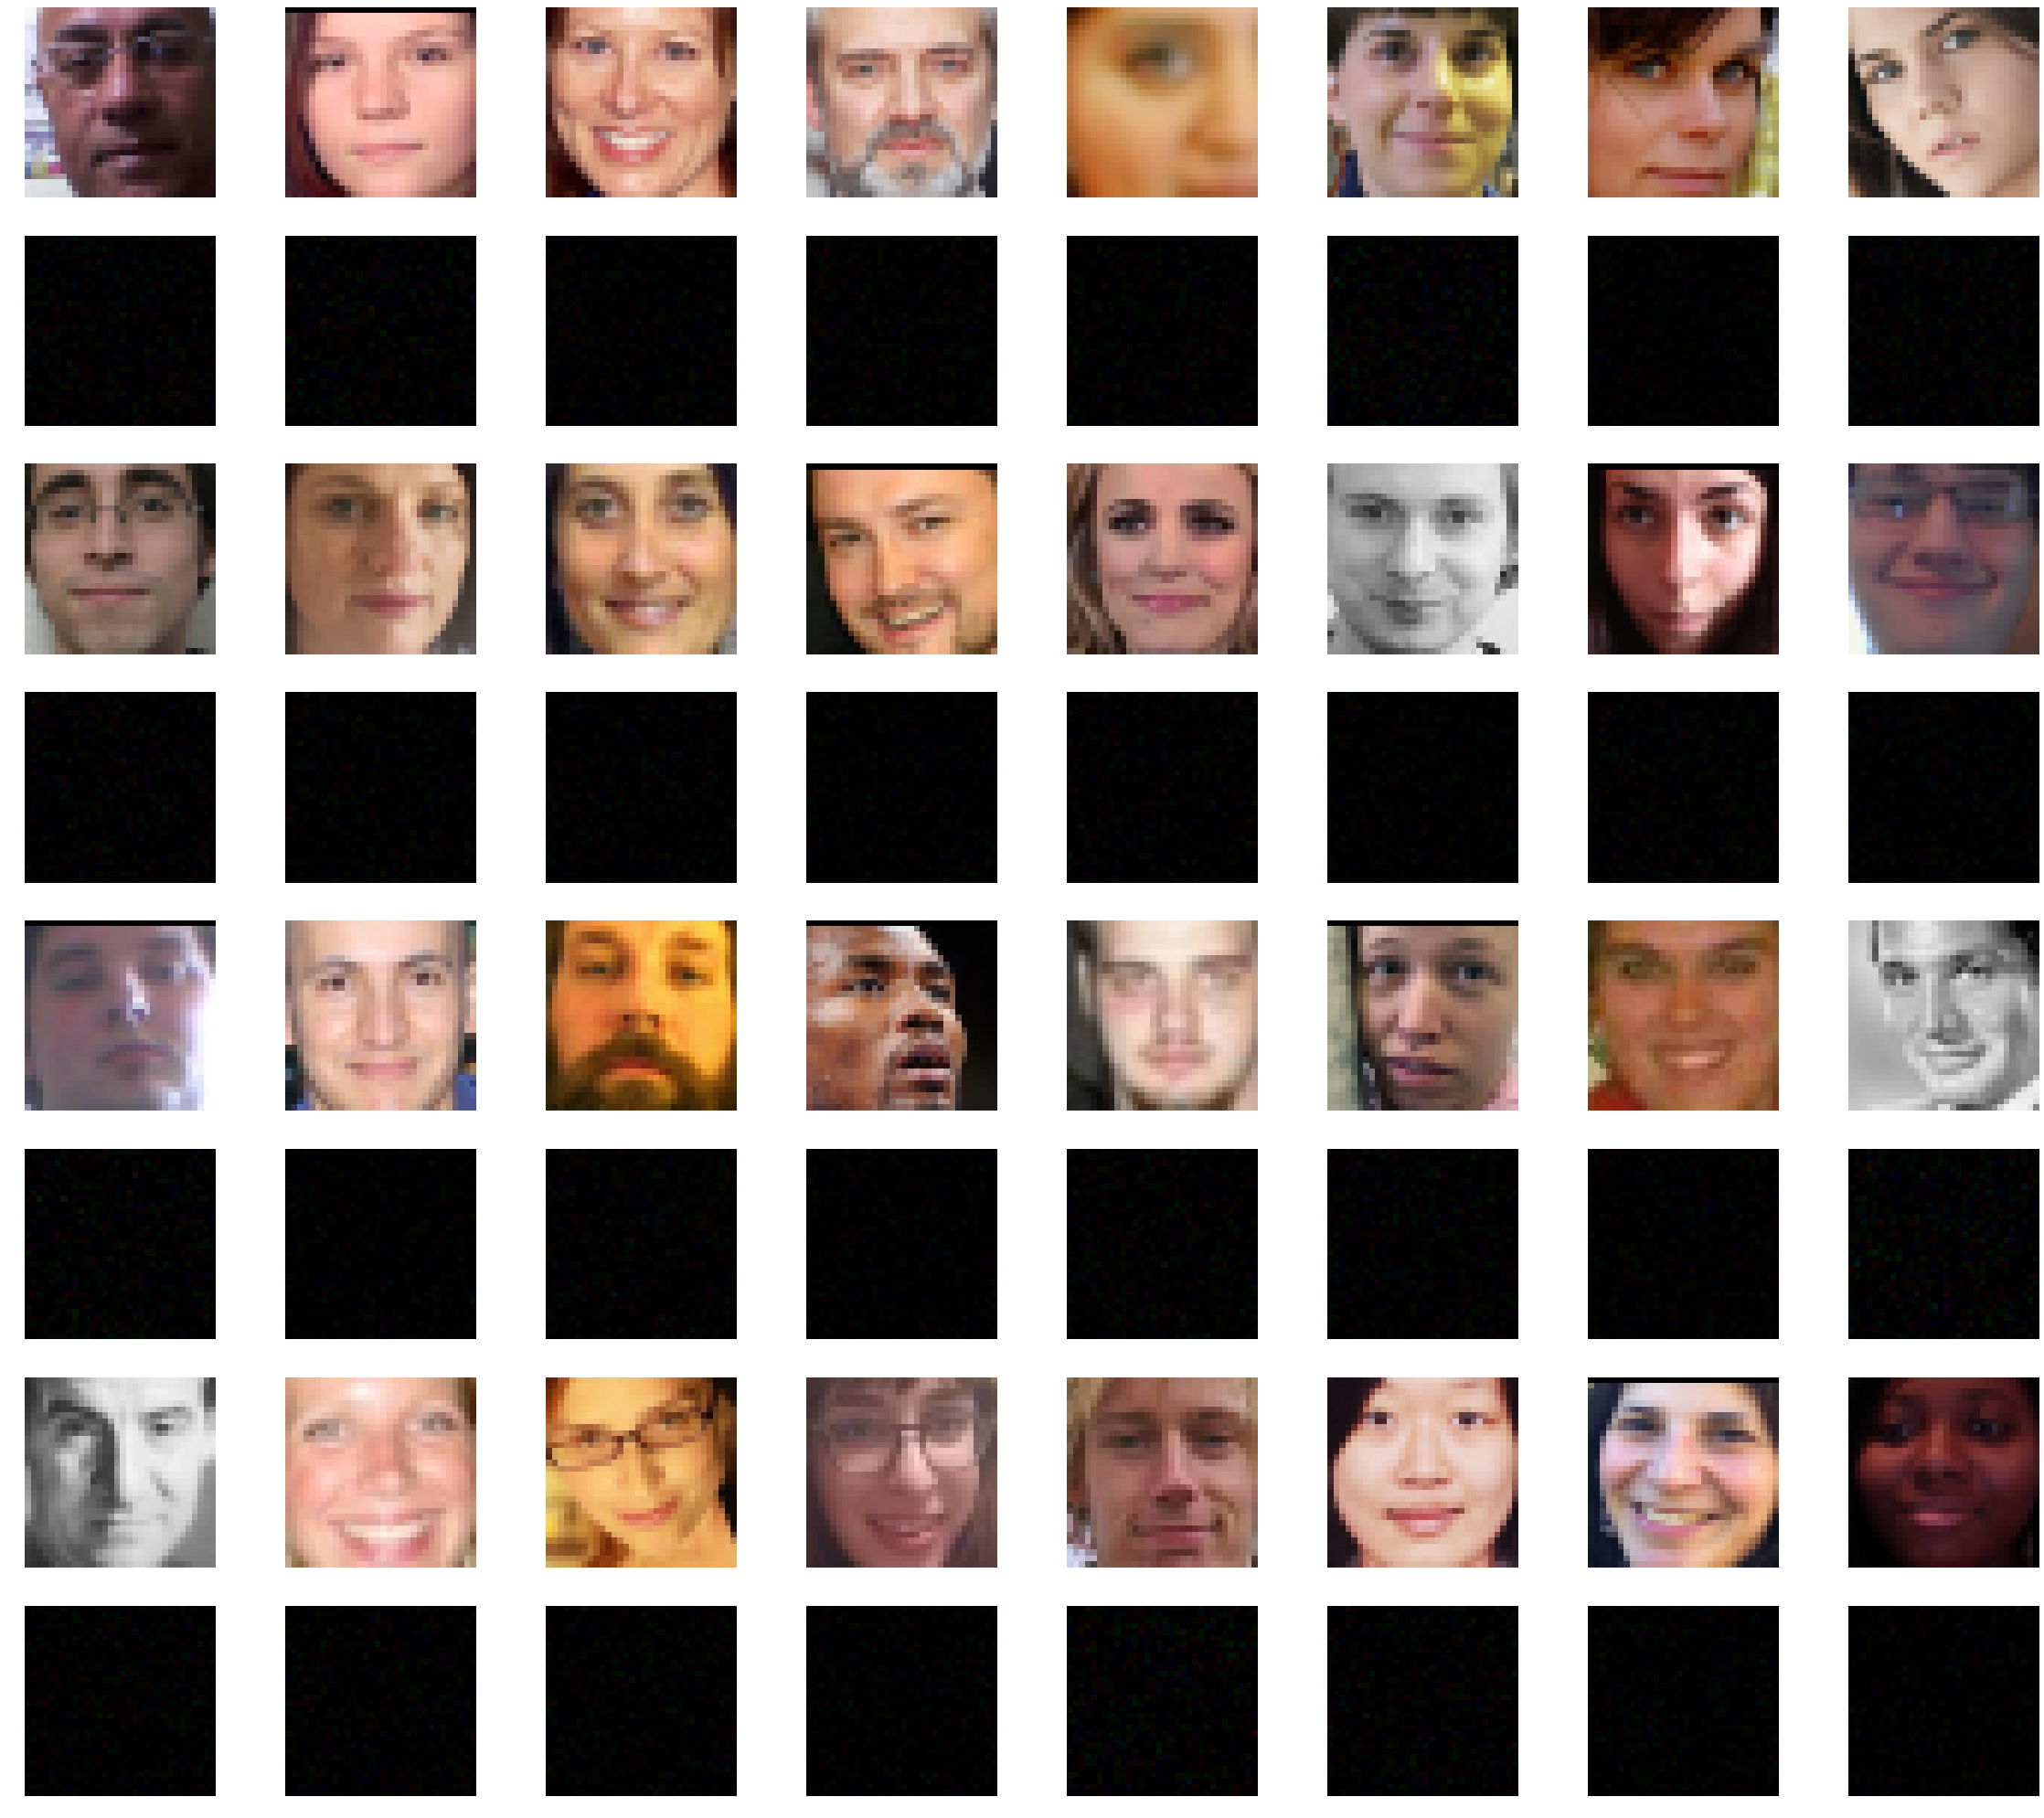

In [41]:
fig, axes = plt.subplots(8, 8, figsize=(40, 36))

r_real = 0
r_fake = 0
for row, axe in enumerate(axes):
    for col, cell in enumerate(axe):
        if row % 2 == 0:
            cell.imshow(z_real[r_real * 8 + col])
        else:
            cell.imshow(z_fake[r_fake * 8 + col])

        cell.axis("off")
    
    if row % 2 == 0:
        r_real += 1
    else:
        r_fake += 1

plt.axis("off")
plt.show();